### Zillow Clustering Project

#### Corey Solitaire - Oct. 21st 2020

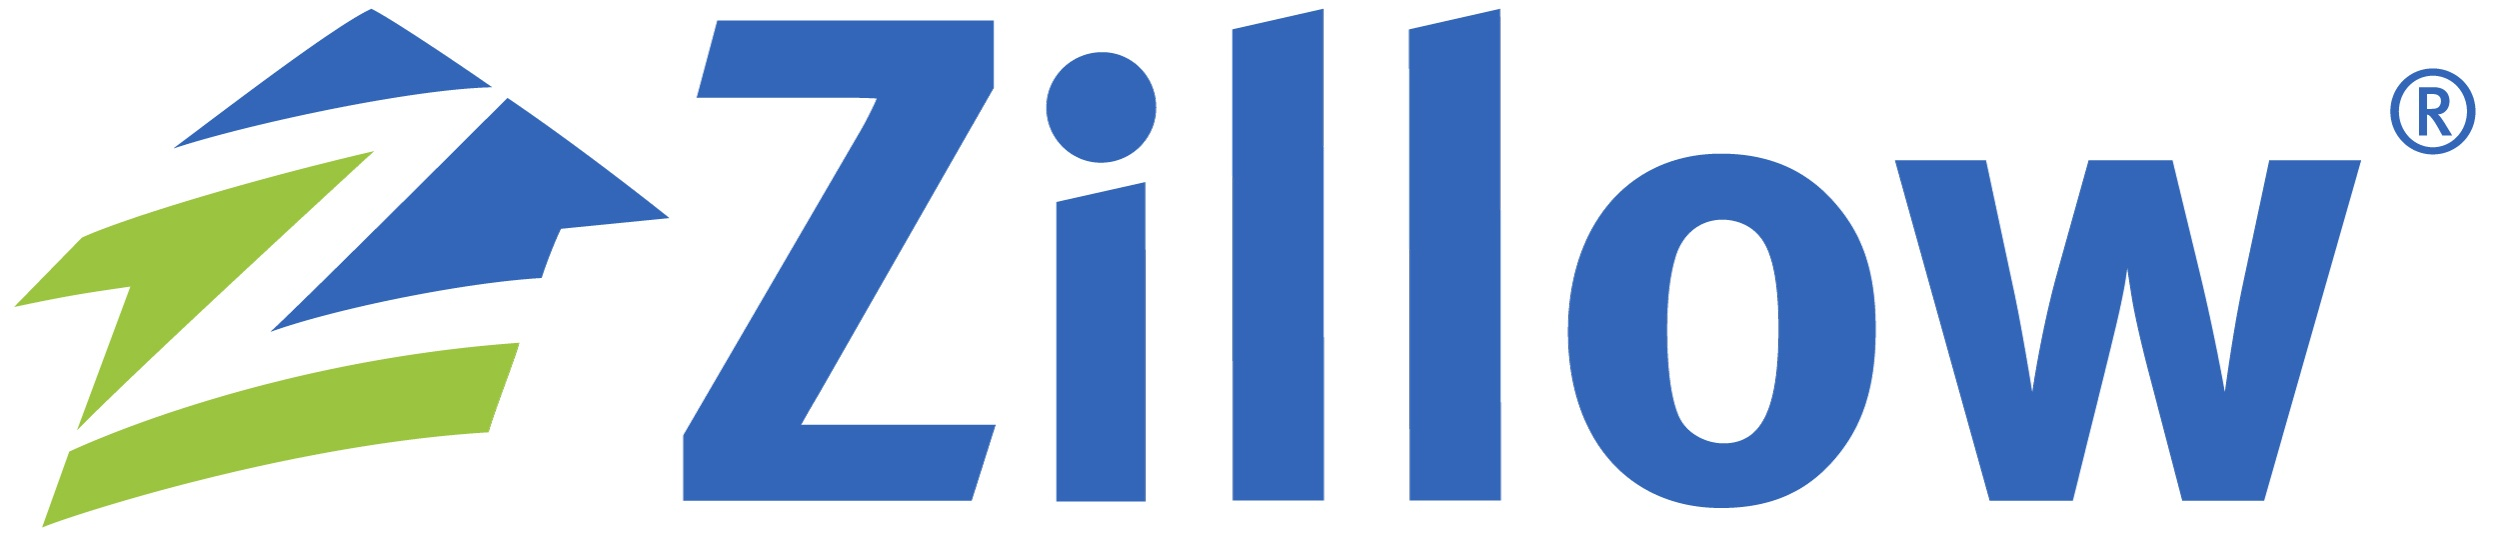

<div class="alert alert-block alert-info"><b></b></div>

# Executive Summary:

***

**Project Summary:**   
*The purpose to this project was to access single unit properties sold in 2007, combine features of those properties in to clusters (feature engeneering) and then develop models based on those features that would best predict logerror (log(Zestimate)−log(SalePrice)).*

**Background:**   
*The Zillow dataset (a competition dataset from Kaggle) consists of information on 2.9 million real estate properties in three counties (Los Angeles, Orange and Ventura, California) sold between October 2016 to December 2017. This project foucuses on the LA County dataset, the largest and most complex of the three.*  

**Process:**   
*3 clusters (room, size, location) were created using the training dataset and 5 of these engeneered features were utilized to build a predictive linear model.  Baseline was estabolished using the mean of the y-train based on the distribution of the data.  Out of several regression model the linear regression model preformed best on train and validate data sets, however it failed to beat baseline on the test data set.*   

**Results and Conclusions:**   
*Modeling produced an average RMSE of 0.17%, however that error represents a -6.87% improvement over baseline.  Model accuracy did not significantly change over train, validate, test suggesting a need for further feature engeneering (cluster design) or different modeling techniques.  There exists the possibility that regression models may not be the best tool to predict logerror in this dataset.*

**Reccomendations:**   
1. *Too Much Data?:Investigate impact of further reducing outliers with regards to logerror.* 

2. *Best Features?: reexamine features to produce new clusters that are better able to predict logerror.*

4. *New Model?: Regression models might not the best approch to predict logerror.*

4. *Other Counties?: This model may work better on other CA counties, further investigation is necessary.* 

<div class="alert alert-block alert-info"><b></b></div>

 # Planning:
 
 ***

# Goals:

#### *1. Explore features of Zillow data set and create 3 clusters that are statistically significant in their relationship to logerror.*   

#### *2. Create features from data clusters (or cluster centers as centroids) and use them to train a regressio model to predict logerror.*

#### *3. Determine the drivers of logerror in Zillows Zestimate*

#### *4. Develop and deliver a professional jupyter notebook outlineing your experience and familiarity with the process of data clustering, module creation, and technical delivery.*


***

# Audience:

#### *- Data science team*

***

# Work Flow:

#### 1. Data Acquistion
    - SQL Database
    - wrangle.py
#### 2. Data Preparation
    - wrangle.py
#### 3. Data Exploration
    - Visulaizations
    - Hypothesis testing
    - Cluster creation
        - explore.py
#### 4. Modeling
    - Regression Models
        - explore.py
#### 5. Conclusions
    - Claim, Evidence, Reasoning
#### 6. Next Steps
    - The goood, the bad, the ugly
    - Tips for improvement

***

<div class="alert alert-block alert-info"><b></b></div>

### Imports:

In [1]:
import wrangle
import explore
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:20,.2f}'.format

from math import sqrt
from scipy import stats
from scipy.stats import f_oneway

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

<div class="alert alert-block alert-info"><b></b></div>

# Data Acquisition:

### SQL Querry

In [2]:
sql_query = '''
                select prop.parcelid
                , pred.logerror
                , bathroomcnt
                , bedroomcnt
                , calculatedfinishedsquarefeet
                , fips
                , latitude
                , longitude
                , lotsizesquarefeet
                , regionidcity
                , regionidcounty
                , regionidzip
                , yearbuilt
                , structuretaxvaluedollarcnt
                , taxvaluedollarcnt
                , landtaxvaluedollarcnt
                , taxamount
            from properties_2017 prop
            inner join predictions_2017 pred on prop.parcelid = pred.parcelid
            where propertylandusetypeid = 261;
                '''

### Explanation

*Following the walkthrough I class I modified my SQL querry to match.  In previous attemps to build predictive models on the Zillow data trying to determine single unit properties was a real concern.  By focusing on a single property land luse type (261) I was able to focus my search on properties that are defined as single units, thus providing me with better data for exploration and modeling.  This querry also focuses on properties of the Zillow data set that are largely numeric and intact.  Being more selective on the import from SQL saved me time and energy and allowed me to focus on my goal of cluster creation and predictive modeling.*  

### Import Modlue (wrangle.py)

- **def get_connection()** 
    - This function uses an env file to estabolish a connection url to access the Codeup db.
- **def new_zillow_data()**
    - This function reads the Zillow customer data from the Codeup db into a df, write to csv, and returns df.
- **def get_zillow_data()**
    - This function reads the Zillow data from the csv and returns a df

<div class="alert alert-block alert-info"><b></b></div>

# Data Preparation:

### Clean Data (wrangle.py)

In [3]:
def clean_zillow_data(df): 
    df.latitude = df.latitude / 1000000
    df.longitude = df.longitude / 1000000
    df = get_counties(df)
    df = create_features(df)
    df = remove_outliers(df)
    df = col_to_drop_post_feature_creation(df)
    mask = df['bed_bath_ratio'] != np.inf
    df.loc[~mask, 'bed_bath_ratio'] = df.loc[mask, 'bed_bath_ratio'].max()
    df.dropna(inplace=True)
    df_la, df_v, df_o = county_df(df)
    return df_la, df_v, df_o

### Explanation  

**clean_zillow_data():** Takes care of all the cleaning I needed to do in my dataset.  First it devides latitude and longitude by 1000000 to express them in units that can be mapped.  Scaling these numbers also narrows range in the variable and makes it better for modeling. It also drops all missing values after data cleaning and returns 3 dataframes (specific to county).    

**get_counties():** Takes the dataframe and create a new column called 'county' that uses the fips data to encode county ID as LA, Ventura, or Orange.  

**create_features():** Creates new features from existing data.  The new features created include **age** calculated by subtracting 2017 - 'yearbuilt', **taxrate** calculated by diviging 'taxamount'/'taxvaluedollarcnt', **acres** caluclated by dividing 'lotsizesquarefeet' / 43560, **structure_dollar_per_square_foot** by dividing 'structurevaluetaxdollarcnt' / 'calculatedfinishedsquarefeet', **land_dollar_per_square_foot** by dividing 'taxvaluedolarcnt' / 'lotsizesquarefeet', and finally **bed_bath_ratio** by dividing 'bedroomcnt' / 'bathroomcnt'.  
**remove_outliers():** Remove extreme outliers in a variety of features.  First it limits the returned data frame to properties with 1 - 7 baths, and 1 - 7 bedrooms. It then corrects the error in zip, removing properties where the zip codes that are greather then 6 numbers.  It removes properties with square feet > 7000, removes lot sizes (acres) > 10, and finally it removes properties where the tax rate is > 5% (6% is national average).    

**col_to_drop_post_feature_creation():** Drops colums used to create new features.  Specifically it drops 'bedroomcnt', 'taxamount','taxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt','lotsizesquarefeet', "regionidzip", "yearbuilt",'parcelid','regionidcity'.  There colums are not longer necessary because the engeneerd featurs now represent the information they hold in a way that reduces collinearity. 

**county_df():** Takes the cleaned data and breaks it in to three dataframes, one for each of the counties reprsented in the Zillow data set.  Previous investigations and hypothesis tests indicated a signficant difference in logerror between counties and these individual datasets provide a means to examine the drivers of logerror in isolation.  
***

<div class="alert alert-block alert-info"><b></b></div>

# Data Exploration:

### Why 3 Data Frames?

In [4]:
df = wrangle.get_zillow_data(cached=True)
df_la, df_v, df_o, df_clean = wrangle.clean_zillow_data(df)
df_clean.head()

,logerror,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
0,0.03,3.50,"3,100.00",33.63,-117.87,0,1,0,19.00,0.01,0.10,156.68,119.30,1.14
1,0.06,1.00,"1,465.00",34.45,-119.28,0,0,1,50.00,0.01,0.29,60.07,29.73,2.00
2,0.01,2.00,"1,243.00",33.89,-117.82,0,1,0,55.00,0.01,0.19,68.62,56.87,1.50
3,-0.10,3.00,"2,376.00",34.25,-118.24,1,0,0,47.00,0.01,0.30,45.84,2.78,1.33
4,-0.00,3.00,"2,962.00",34.15,-118.18,1,0,0,67.00,0.01,1.45,93.41,7.88,1.33


### Mean Logerror is different  per county:

In [5]:
All = round(df_clean.logerror.mean(),5)
LA = round((df_clean[df_clean.LA == 1]).logerror.mean(),5)
Ventura = round((df_clean[df_clean.Ventura == 1]).logerror.mean(),6)
Orange = round((df_clean[df_clean.Orange == 1]).logerror.mean(),6)

print(f'The logerror for all Counties is {All}') 
print(f'The logerror for LA County is {LA}')
print(f'The logerror for Ventura County is {Ventura}')
print(f'The logerror for Orange County is {Orange}')

The logerror for all Counties is 0.01821
The logerror for LA County is 0.01514
The logerror for Ventura County is 0.015201
The logerror for Orange County is 0.026497


### Is This Difference Statistically Significant? (ANOVA)

**Question** - Is there significant difference in Logerror (99% Confidence) between Counties?

*null* = Mean logerror is the same across all Counties   
*alternate* = Average logerror is significantly different Counties   
*alpha* = **0.01** (Let's be 99% certain the result we see isn't due to chance/randomness)   

In [6]:
# f_oneway is our ANOVA test
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html for more info

All = df_clean.logerror
LA = (df_clean[df_clean.LA == 1]).logerror
Ventura = (df_clean[df_clean.Ventura == 1]).logerror
Orange = (df_clean[df_clean.Orange == 1]).logerror

alpha = 0.01
null = "Mean logerror is the same across all counties"
alternate = "Average logerror is significantly different between counties"

f, p = f_oneway(All, LA, Ventura, Orange)
if p < alpha:
    print("We reject the null that:", null)
    print("We move forward with the alternative hypothesis that:", alternate)
else:
    print("We fail to reject the null")
    print("Evidence does not support the claim that smoking status and time of day are dependent/related")

We reject the null that: Mean logerror is the same across all Counties
We move forward with the alternative hypothesis that: Average logerror is significantly different Counties


***Takeaway***   
*Significant Difference Between Counties = Counties are one factor that drives Logerror*

***

# Data Exploration: LA County

In [7]:
X_train, X_validate, X_test, X_train_explore, X_train_explore_scaled, y_train, y_validate, y_test, X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.split_scale(df_la)
X_train_explore.head()

,logerror,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
50028,0.03,3.00,"2,313.00",34.16,-118.42,1,0,0,55.00,0.01,0.16,151.44,72.58,1.33
16721,-0.02,1.00,"1,232.00",34.23,-118.25,1,0,0,91.00,0.01,0.17,18.40,13.69,3.00
30822,0.07,1.00,"1,213.00",34.03,-118.46,1,0,0,66.00,0.01,0.13,91.47,141.76,3.00
4398,0.03,2.00,"1,920.00",34.02,-118.32,1,0,0,95.00,0.01,0.13,62.68,41.50,1.50
46912,-0.01,2.00,"1,268.00",33.91,-118.13,1,0,0,63.00,0.02,0.12,28.23,5.11,1.50


### Looking for Clusters: (Square Footage, Bed Bath Ratio, Logerror)

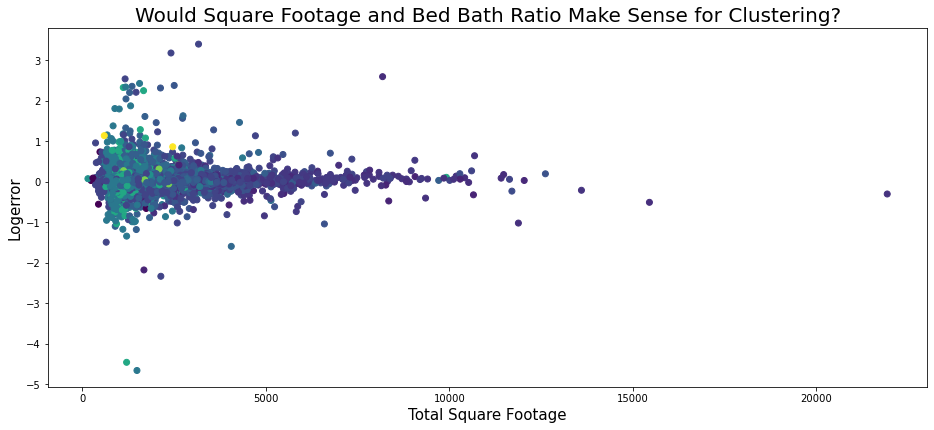

In [8]:
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.scatter(X_train_explore.calculatedfinishedsquarefeet, X_train_explore.logerror, c=X_train_explore.bed_bath_ratio)
plt.xlabel("Total Square Footage", fontsize=15 )
plt.ylabel("Logerror", fontsize=15)
plt.title("Would Square Footage and Bed Bath Ratio Make Sense for Clustering?",fontsize=20)
plt.tight_layout(pad =8)
plt.show()


**Takeaway:**

*Shows some promise, appears to be a good canidate for cluster creation*

***

### Looking for Clusters: (Structure Dollar Per Sqft, Logerror)

In [22]:
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

x = X_train_explore.structure_dollar_per_sqft
y = X_train_explore.logerror
stat_func = r2(x,y)
stat_func

0.002443475275844582

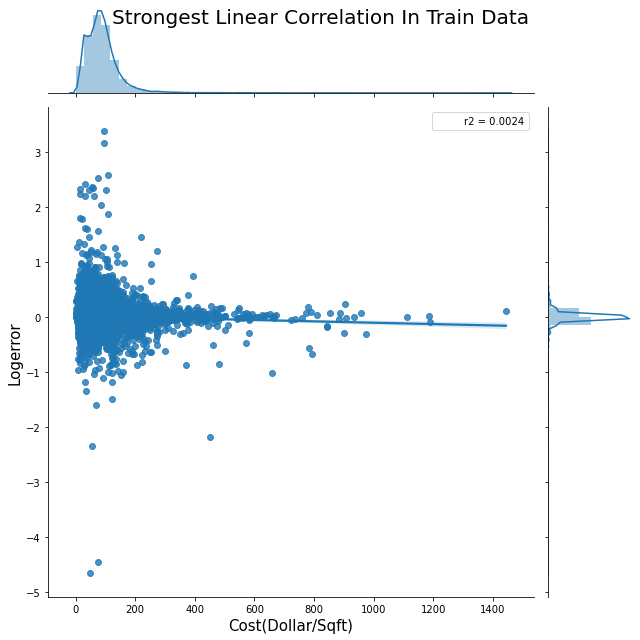

In [18]:
h = sns.jointplot(x, y, kind="reg", stat_func=r2, height=9, ratio=5, space=1)
h.fig.suptitle("Strongest Linear Correlation In Train Data", fontsize = 20)
h.set_axis_labels('Cost (Dollar/Sqft)', 'Logerror', fontsize=15)
plt.tight_layout()

#### Takeaway: 

*Highest linear correlation between features and target was **Cost (Dollars/Sqft)** with an r-squared value of 0.00092.  Suggest this feature should be included as a feature.*

***

# I Found Some Good Leads, Now What?

### Three Clusters:

1. **room_cluster:** *Consists of calculatedfinishedsquarefeet, bed_bath_ratio, bathroomcnt*
    - These cluster grouped nicely when visulized in the scatterplot.  The cluster will focus on features that relate to the number of rooms per property.  
    
    
2. **price_cluster:** *Consitst of taxrate, structure_dollar_per_sqft, land_dollar_per_sqft*
    - This cluster utilize the relationship between cost per sqft and logerror to produce a feature that focuses on the cost features of the property.  


3. **location_cluster:** *Consists of latitude, longitude, room_cluster, price_cluster*
    - This cluster takes the location of the property and blends it togher with the room and price cluster
    
***

### Cluster #1: room_cluster:

#### Elbow Plot


   k                  sse
0  1               492.58
1  2               245.24
2  3               152.44
3  4               102.44
4  5                71.00
5  6                59.45
6  7                48.26
7  8                38.27
8  9                31.17


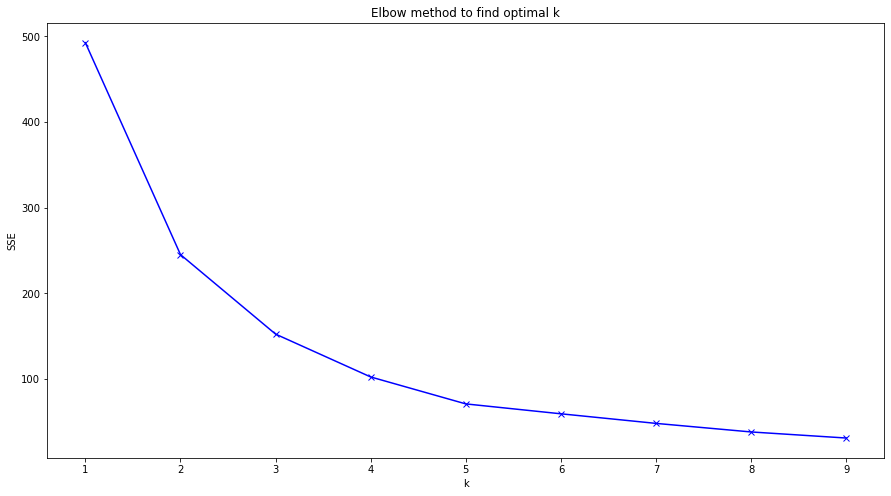

In [23]:
cluster_vars = ['bathroomcnt', 'bed_bath_ratio', 'calculatedfinishedsquarefeet']
explore.elbow_plot(X_train_scaled, cluster_vars)

#### Create Clusters

In [25]:
train_clusters, kmeans = explore.run_kmeans(X_train, X_train_scaled, k=4, cluster_vars=cluster_vars, cluster_col_name = 'room_cluster')
validate_clusters = explore.kmeans_transform(X_validate_scaled, kmeans, cluster_vars, cluster_col_name = 'room_cluster')
test_clusters = explore.kmeans_transform(X_test_scaled, kmeans, cluster_vars, cluster_col_name = 'room_cluster')

#### Get Centroids

In [26]:
centroids = explore.get_centroids(cluster_vars, cluster_col_name='room_cluster', kmeans= kmeans)

#### Append Cluster and Join Centroids

In [27]:
X_train, X_train_scaled = explore.add_to_train(train_clusters, centroids, X_train, X_train_scaled, cluster_col_name = 'room_cluster')
X_train_explore, X_train_explore_scaled = explore.add_to_train(train_clusters, centroids, X_train_explore, X_train_explore_scaled, cluster_col_name = 'room_cluster')
X_validate, X_validate_scaled = explore.add_to_train(validate_clusters, centroids, X_validate, X_validate_scaled, cluster_col_name = 'room_cluster')
X_test, X_test_scaled = explore.add_to_train(test_clusters, centroids, X_test, X_test_scaled, cluster_col_name = 'room_cluster')

#### Visualize Clusters

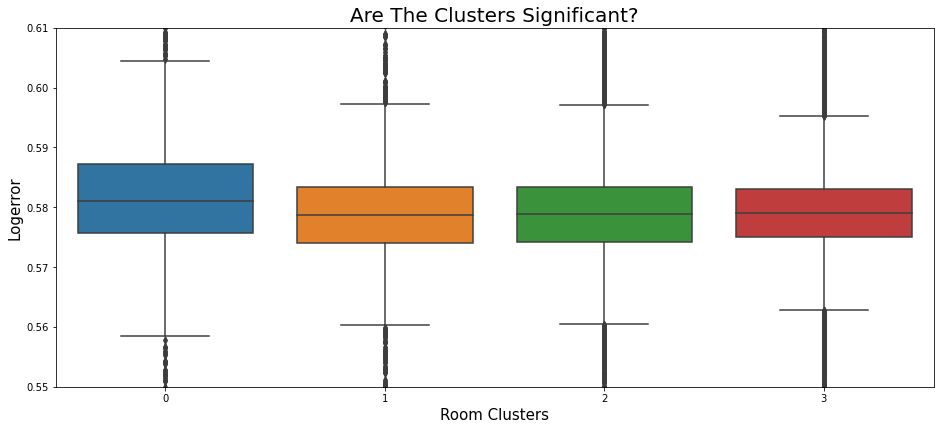

In [37]:
plt.rcParams['figure.figsize'] = (15.0, 8.0)
sns.boxplot(X_train_explore_scaled.room_cluster, X_train_explore_scaled.logerror)
plt.xlabel("Room Clusters", fontsize=15 )
plt.ylabel("Logerror", fontsize=15)
plt.title("Are The Clusters Significant?",fontsize=20)
plt.tight_layout(pad =8)
plt.ylim(.55,.61)
plt.show()
#X_train_explore_scaled.head()

***

### Hypothesis Testing: (ANOVA)

Is there a staistically signfinicant difference between room_clusters and logerror?

***Null Hypothesis:*** Mean logerror is the same across all clusters

***Alternative Hypothesis:*** Mean logerror is different across clusters

**alpha=0.01**

In [39]:
cluster_0 = X_train_explore_scaled[X_train_explore_scaled.room_cluster == 0].logerror
cluster_1 = X_train_explore_scaled[X_train_explore_scaled.room_cluster == 1].logerror
cluster_2 = X_train_explore_scaled[X_train_explore_scaled.room_cluster == 2].logerror
cluster_3 = X_train_explore_scaled[X_train_explore_scaled.room_cluster == 3].logerror

alpha = 0.01
null = "Mean logerror is the same across all clusters"
alternate = "Average logerror is significantly different between clusters"

from scipy.stats import f_oneway
f, p = f_oneway(cluster_0, cluster_1, cluster_2, cluster_3)
if p < alpha:
    print("We reject the null that:", null)
    print("We move forward with the alternative hypothesis that:", alternate)
else:
    print("We fail to reject the null")
    print("Evidence does not support the claim that smoking status and time of day are dependent/related")

We reject the null that: Mean logerror is the same across all clusters
We move forward with the alternative hypothesis that: Average logerror is significantly different between clusters


In [ ]:

### LA County - (Greatest # of Homes, Greatest Variety of Homes) 
    - Visualize
### Cluster Selection (3)
    - Explaination
    - Visualize
    - Hypothesis Test

In [ ]:
# Modeling:

### Determine Baseline
    -Visualize
    -Explain
    
### 1st Iteration
    -Model
    -Result
    -Conclusion

In [ ]:
# Conclusions:
    -Summary of Findings

In [ ]:
# Next Steps: 
    - Summy of What Next